<a href="https://colab.research.google.com/github/katharina-knappmann/wildfire_challenge/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random Forest Implementation**
*This notebook processes data provided by the [IBM Call for Code Wildfire Challenge](https://community.ibm.com/community/user/datascience/blogs/susan-malaika/2020/11/10/call-for-code-spot-challenge-for-wildfires). The unpreprocessed data is available [on GitHub](https://github.com/Call-for-Code/Spot-Challenge-Wildfires).*

The notebook consists of the following process steps:

*   loading preprocessed data and weather forecast
*   split the data into training, validation and test data
*   normalize data
*   generate predictions on validation data
*   getting feature importances
*   plot result
*   visualization of decision tree
*   Random Forest creation based on training data


In [105]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import time
import random

from google.colab import drive
from matplotlib import pyplot as plt
from collections import deque

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*   loading preprocessed data and weather forecast

In [106]:
df = pd.read_csv('Cleansed_Data.csv')
forecasts_df = pd.read_csv('HistoricalWeatherForecasts.csv')

df['Date'] = pd.to_datetime(df['Date'])
forecasts_df['Date'] = pd.to_datetime(forecasts_df['Date'])

df = df.drop(columns=['Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power'], inplace=False)

first_col = df.pop('Estimated_fire_area')
df.insert(0, 'Estimated_fire_area', first_col)

*     normalize Data

In [107]:
scaler = MinMaxScaler()
for col in df:
  if col not in ['Estimated_fire_area', 'Region', 'Date']:
    df[[col]] = scaler.fit_transform(df[[col]])

*   split the data into training, validation and test data

In [108]:
#TEST DATA

df = df.set_index('Date', inplace=False)
splitting_date = np.datetime64('2021-01-13T00:00:00.000000000')
test_df = df[(df.index >= splitting_date)]
df = df[(df.index <= splitting_date)] # weil letztes datum nur für vorberechnung genutzt wird kann es in die testdaten

#VALIDATION AND TRAINING DATA

splitting_date = sorted(df.index.values)[-200]
val_df = df[(df.index >= splitting_date)].copy()
val_df.sample(n = val_df.shape[0])
train_df = df[(df.index < splitting_date)].copy()
train_df = train_df.sample(n = train_df.shape[0])

def split_x_and_y(df):
  df_arr = df.copy()
  df_arr.reset_index(inplace=True)
  df_arr.drop(columns=['Region', 'Date'], inplace=True)
  arr = np.asarray(df_arr)
  x = arr[:,1:]
  y = arr[:,0:1].ravel()
  return x,y

train_x, train_y = split_x_and_y(train_df)
val_x, val_y = split_x_and_y(val_df)
test_x, test_y = split_x_and_y(test_df)

*   Random Forest creation based on training data

In [140]:
rf = RandomForestRegressor(n_estimators = 250, criterion='mse', 
                           max_features='auto', min_samples_leaf=10, 
                           bootstrap=True, max_depth=25, oob_score=True, n_jobs=2)
rf.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

*   generate predictions on validation data

In [117]:
def createPrediction(df):
  df_all = pd.DataFrame()
  for region in ['NSW', 'VI', 'TA', 'SA', 'WA', 'QL', 'NT']:
    df_new = pd.DataFrame()
    df_temp = df[df['Region'] == region].copy()
    df_temp['Region'] = region
    df_new['Change'] = df_temp['PREDICTIONS'] - df_temp['PREDICTIONS'].shift(1)
    df_new['NEW'] = df_new.Change - df_temp.ACTUAL
    df_new[df_new < 0] = 0
    df_all = df_all.append(df_new)
  return df_all.NEW

In [143]:
def getPrediction(df, x):
  predictions = rf.predict(x)

  df_result = df[['Region']].copy()
  df_result.reset_index(inplace=True)
  df_result['PREDICTIONS'] = pd.DataFrame(predictions.reshape(-1, 1), columns=['PREDICTIONS'])
  df_result.insert(value = pd.DataFrame(val_y.reshape(-1, 1)), column='ACTUAL', loc=3)
  df_result['PREDICTIONS'] = createPrediction(df_result)
  df_result['DIFFERENCE'] = df_result.PREDICTIONS - df_result.ACTUAL
  df_result.dropna(inplace=True)

  print('ACCURACY RESULTS')
  print('Mean Absolute Error:', round(df_result.DIFFERENCE.mean(),2),'.')
  print('Root Mean Squared Error:',mean_squared_error(np.asarray(df_result.ACTUAL), np.asarray(df_result.PREDICTIONS), squared=False),'.')
  #print('R Squared:',r2_score(np.asarray(df_result.ACTUAL), np.asarray(df_result.PREDICTIONS)),'.')
  print('Maximum Prediction Difference', df_result.DIFFERENCE.max(),'.')
  print(df_result.head())
  print('_______________________________')


getPrediction(val_df, val_x)
getPrediction(test_df, test_x)

ACCURACY RESULTS
Mean Absolute Error: -3.13 .
Root Mean Squared Error: 19.217422658264752 .
R Squared: -0.34790373639904515 .
Maximum Prediction Difference 53.52008158063938 .
        Date Region  PREDICTIONS  ACTUAL  DIFFERENCE
1 2020-12-17    NSW     2.594990     0.0    2.594990
2 2020-12-18    NSW     0.000000     0.0    0.000000
3 2020-12-19    NSW     0.000000     0.0    0.000000
4 2020-12-20    NSW     0.088639     0.0    0.088639
5 2020-12-21    NSW     0.833199     0.0    0.833199
_______________________________
ACCURACY RESULTS
Mean Absolute Error: -0.92 .
Root Mean Squared Error: 17.41478604981962 .
R Squared: -0.7269604105969438 .
Maximum Prediction Difference 55.02940698942925 .
        Date Region  PREDICTIONS  ACTUAL  DIFFERENCE
1 2021-01-14    NSW     0.000000     0.0    0.000000
2 2021-01-15    NSW    13.334085     0.0   13.334085
3 2021-01-16    NSW     8.668077     0.0    8.668077
4 2021-01-17    NSW     0.000000     0.0    0.000000
5 2021-01-18    NSW     0.426526   

*    plot result

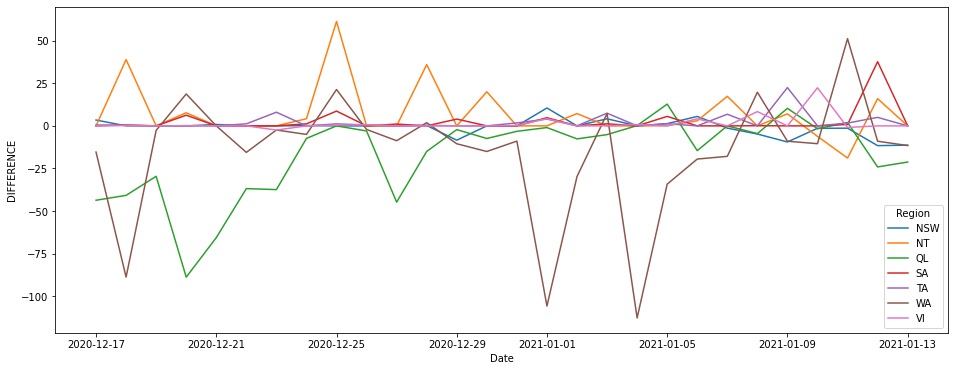

In [144]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x="Date", y="DIFFERENCE", hue='Region', data=df_result)

*   visualization of decision tree

In [113]:
from sklearn.tree import export_graphviz
import pydot

#tree = rf.estimators_[5]# Pull out one tree from the forest
#export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
#graph.write_png('tree.png')

*   getting feature importances

In [114]:
features = df.drop(columns=['Estimated_fire_area'], inplace=True)
feature_names = df.columns

importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Closed forest, unknown_inflame_risk Importance: 0.3
Variable: RelativeHumidity_Variance Importance: 0.11
Variable: RelativeHumidity_Max Importance: 0.1
Variable: Open forest, unknown definitions_inflame_risk Importance: 0.07
Variable: SolarRadiation_Max   Importance: 0.04
Variable: Month                Importance: 0.04
Variable: Precipitation_Max    Importance: 0.02
Variable: SoilWaterContent_Max Importance: 0.02
Variable: SoilWaterContent_Min Importance: 0.02
Variable: SoilWaterContent_Variance Importance: 0.02
Variable: Vegetation_index_mean Importance: 0.02
Variable: Vegetation_index_min Importance: 0.02
Variable: Vegetation_index_std Importance: 0.02
Variable: Precipitation_Min    Importance: 0.01
Variable: Precipitation_Variance Importance: 0.01
Variable: RelativeHumidity_Mean Importance: 0.01
Variable: RelativeHumidity_Min Importance: 0.01
Variable: SolarRadiation_Mean  Importance: 0.01
Variable: SolarRadiation_Min   Importance: 0.01
Variable: SolarRadiation_Variance Im

In [115]:
rf.estimators_

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=266176250, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1713300013, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impu